In [1]:
import sys
#sys.path.append('..')
from QAOA import QAOArunner
from MaxCutProblem import MaxCutProblem
import params
from rustworkx.visualization import mpl_draw as draw_graph
from load_data import load_graph_from_csv

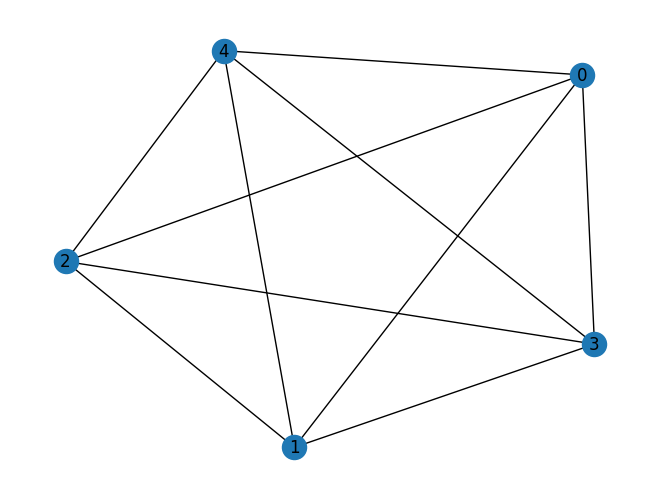

In [2]:
problem = MaxCutProblem()
graph = problem.get_graph(5, create_random=True,random_weights=False)
name= 'F?~vw'


#graph = problem.get_graph_by_name(name)
#graph = load_graph_from_csv('data/11_nodes_links_scand.csv')
#draw_graph(graph, with_labels=True)

draw_graph(graph, with_labels=True)

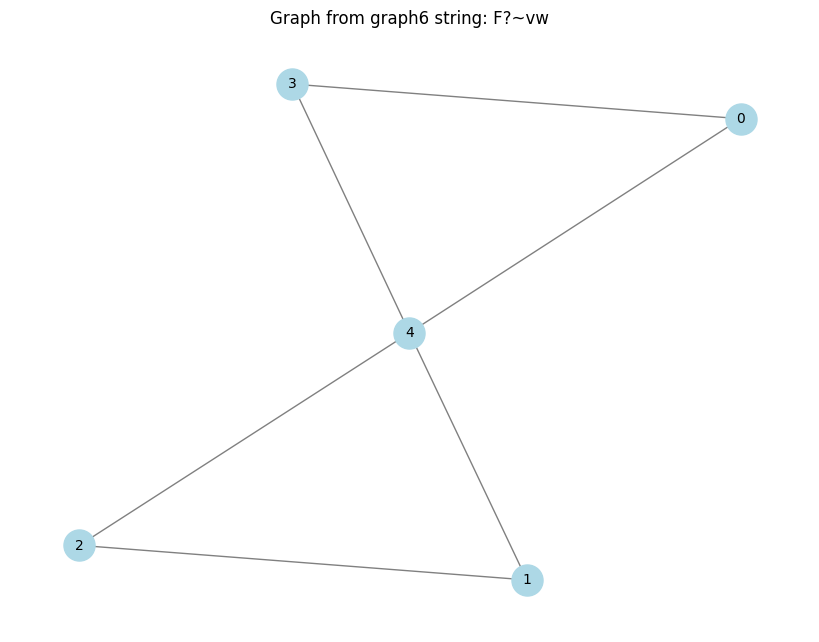

In [3]:
import networkx as nx

import matplotlib.pyplot as plt

# Assuming graph6_str is defined in a previous cell
graph6_str = 'DK{'

# Create a graph from the graph6 string
graph_from_graph6 = nx.from_graph6_bytes(graph6_str.encode())

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(graph_from_graph6, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.title(f"Graph from graph6 string: {name}")
plt.show()

objective: 2x_0*x_3+2x_0*x_4+2x_1*x_2+2x_1*x_4+2x_2*x_4+2x_3*x_4-3x_0-3x_1-3x_2-3x_3-7x_4+12
cst hamultonian after covnersion to qubo minimize 2*x_0*x_3 + 2*x_0*x_4 + 2*x_1*x_2 + 2*x_1*x_4 + 2*x_2*x_4 + 2*x_3*x_4 - 3*x_0 - 3*x_1 - 3*x_2 - 3*x_3 - 7*x_4 + 12 (5 variables, 0 constraints, 'VertexCover')
ising hamiltonian: (SparsePauliOp(['IIIIZ', 'IZIII', 'IIIZI', 'IIZII', 'ZIIII', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 1.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j]), 5.5)
SparsePauliOp(['IIIIZ', 'IZIII', 'IIIZI', 'IIZII', 'ZIIII', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 1.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j])
[1, 1, 0, 0, 1]
3
321
[1.84744633 3.57353826 0.9664792  0.33601858 1.44314252 0.94751098
 2.91597083 2.39828482 3.66013733 1.80661224 0.16266274 1.64293608
 4.38987048 1.11642386 4.84193336 2.4698

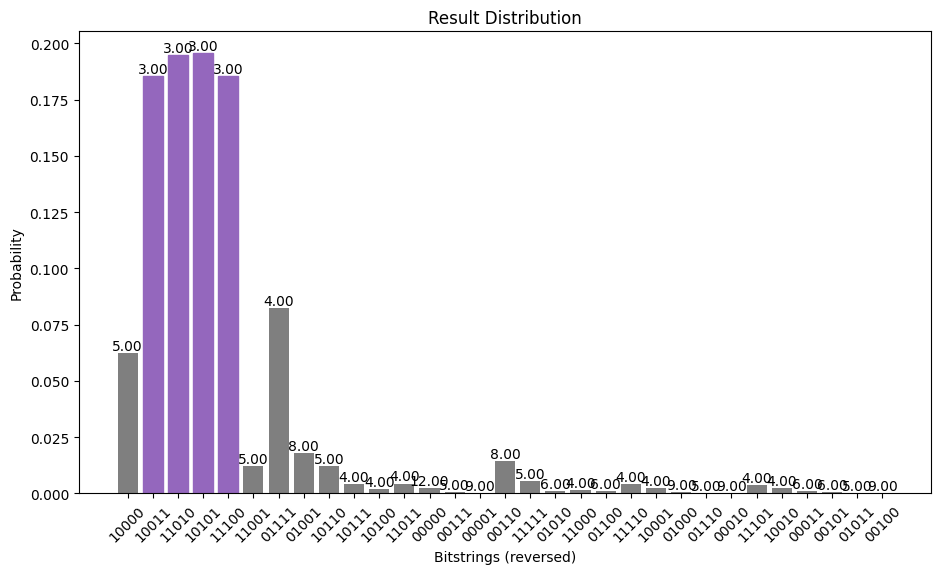

In [15]:
graph = problem.get_paper_graphs()[1]

quantum = QAOArunner(graph=graph, 
                     simulation=True,
                     param_initialization= 'uniform',
                     qaoa_variant='vanilla', 
                     optimizer='COBYLA',
                     warm_start=False,
                     restrictions = False,
                     depth = 10,
                     errors=False,
                     verbose=False,
                     vertexcover=True
                     )

quantum.build_circuit()
quantum.run()
print(quantum.solution)
print(quantum.evaluate_sample())
print(quantum.fev)
print(quantum.result.x)
print(quantum.get_prob_most_likely_solution())
quantum.print_bitstrings()

In [5]:
print(quantum.fev)

337


In [6]:
quantum.get_prob_most_likely_solution()

optimal value found: 3.0
Bitstring [1, 0, 1, 0, 1] has value 3 and probability  0.1564
Bitstring [1, 1, 0, 0, 1] has value 3 and probability  0.1489
Bitstring [0, 0, 1, 1, 1] has value 3 and probability  0.149
Bitstring [0, 1, 0, 1, 1] has value 3 and probability  0.1493
keys: [21, 19, 28, 27, 9, 26, 25, 30, 16, 23, 31, 29, 20, 6, 10, 13, 14, 8, 7, 11, 18, 0, 24, 17, 12, 15, 1, 22, 5, 3, 2, 4]
values: [0.1564, 0.1489, 0.149, 0.0309, 0.0073, 0.1493, 0.015, 0.0335, 0.0517, 0.0294, 0.0174, 0.0311, 0.0073, 0.0077, 0.0034, 0.0189, 0.0197, 0.0007, 0.0202, 0.0204, 0.0067, 0.0135, 0.0085, 0.0088, 0.0034, 0.0198, 0.0011, 0.0134, 0.0032, 0.0019, 0.001, 0.0005]


0.6036

F?~vw (graph6): >>graph6<<DK{


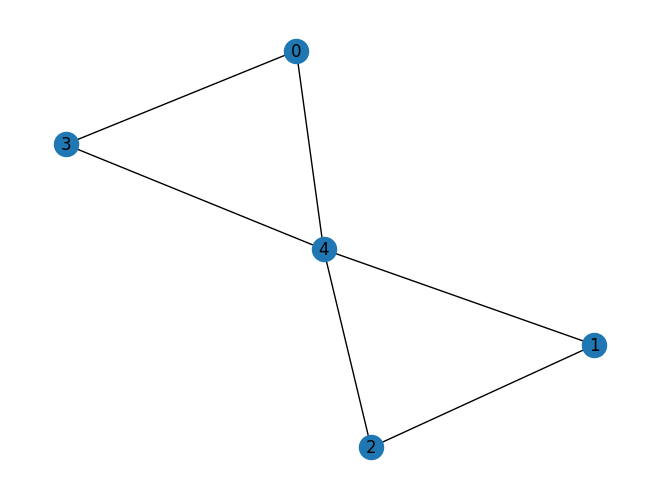

In [7]:
import networkx as nx
draw_graph(graph, with_labels=True)


nx_graph = nx.Graph()
nx_graph.add_nodes_from(range(graph.num_nodes()))
nx_graph.add_weighted_edges_from(graph.weighted_edge_list())
graph6_str = nx.to_graph6_bytes(nx_graph).decode().strip()
print(f"{name} (graph6): {graph6_str}")

Graph (graph6): >>graph6<<DBk


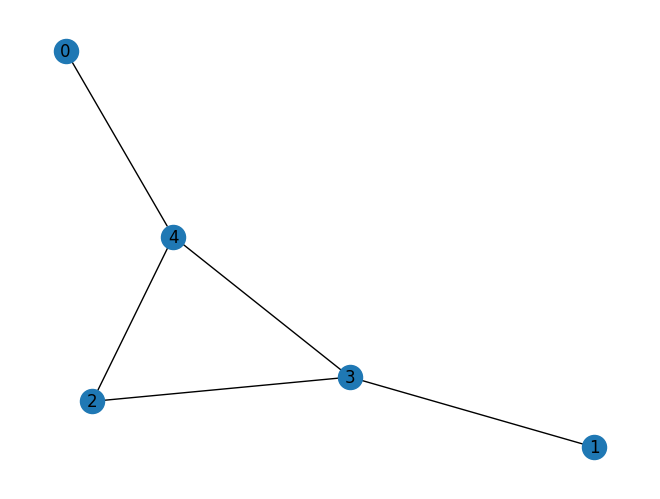

Graph (graph6): >>graph6<<DK{


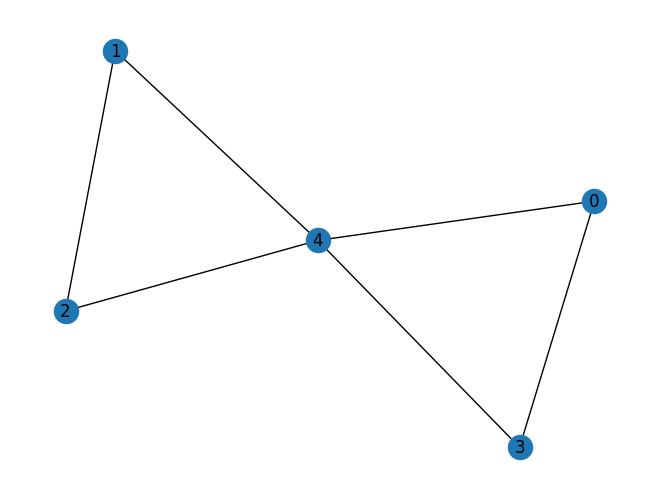

Graph (graph6): >>graph6<<D]{


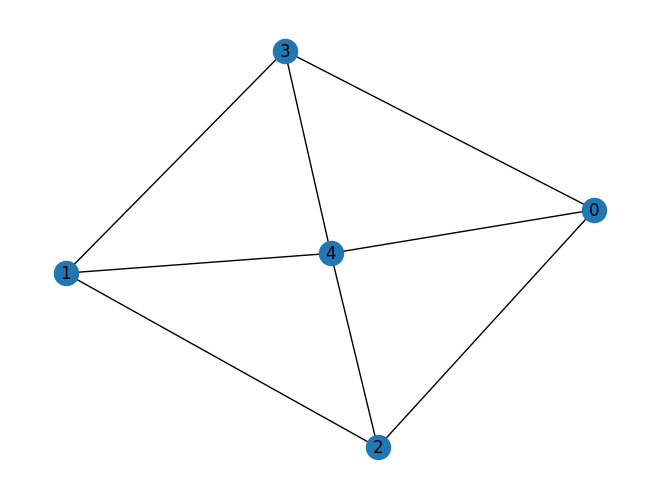

In [8]:
import networkx as nx
import rustworkx as rx
import matplotlib.pyplot as plt

for g in problem.get_paper_graphs():
    draw_graph(g, with_labels=True)
    nx_graph = nx.Graph()
    nx_graph.add_nodes_from(range(g.num_nodes()))
    nx_graph.add_weighted_edges_from(g.weighted_edge_list())
    graph6_str = nx.to_graph6_bytes(nx_graph).decode().strip()
    print(f"Graph (graph6): {graph6_str}")
    plt.show()

0
1
2


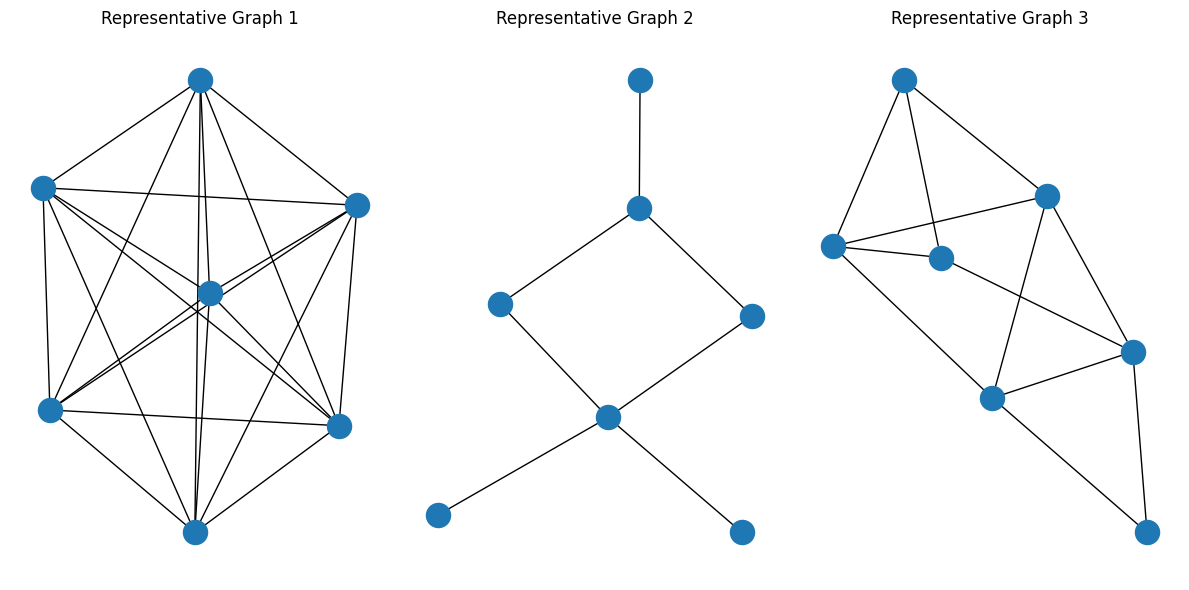

In [9]:
problem.draw_representative_graphs()

In [10]:
problem.print_graphs()

Complete Graph (graph6): >>graph6<<F~~~w
Sparse Graph (graph6): >>graph6<<FS_Bg
Dense Graph (graph6): >>graph6<<FS^l_


In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=params.api_key
)

job = service.job('cxg38m26t010008cmsng') #You can get this on the ibmq web interface 
job_result = job.result()
job_approx_execution_time = job.metrics() 
print(job_approx_execution_time)
for key, value in job_approx_execution_time.items():
    print(f"{key}: {value}")

RuntimeJobNotFound: 'Job not found: 404 Client Error: Not Found for url: https://api.quantum.ibm.com/runtime/jobs/cxg38m26t010008cmsng. {"errors":[{"code":1291,"message":"Job not found. Job ID: cxg38m26t010008cmsng","solution":"Verify the job ID is correct, and that you have the correct access permissions.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}'

In [ ]:
import itertools
param_initialization = ['gaussian']
optimizer = ['COBYLA']
qaoa_variant = ['vanilla']
warm_start = [False]
errors = [True]
depth=[10,12]

iterables = [param_initialization, optimizer, qaoa_variant,warm_start,errors, depth] 
settings = list(itertools.product(*iterables))
print(f'echo "{settings}" > test_settings.txt')

echo "[('gaussian', 'COBYLA', 'vanilla', False, True, 10), ('gaussian', 'COBYLA', 'vanilla', False, True, 12)]" > test_settings.txt


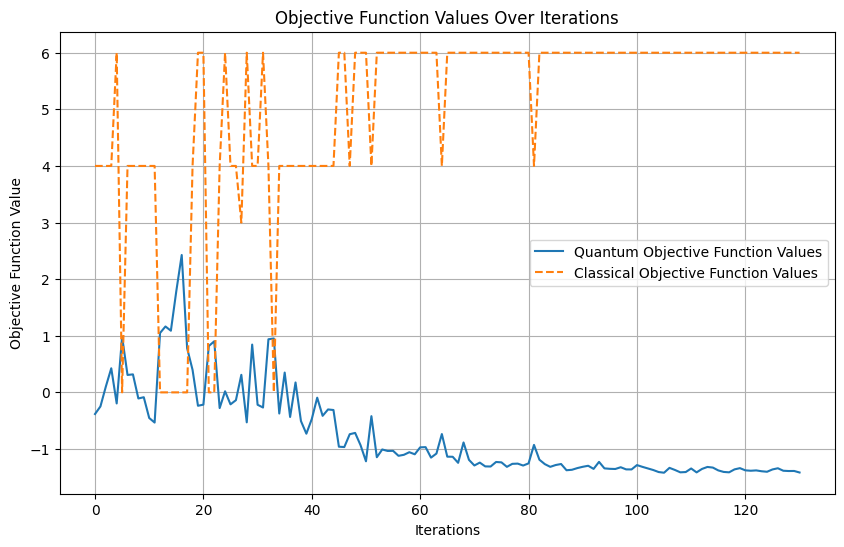

In [ ]:
import matplotlib.pyplot as plt

# Assuming quantum.objective_func_vals and quantum.classical_objective_func_vals are lists or arrays
plt.figure(figsize=(10, 6))
plt.plot(quantum.objective_func_vals, label='Quantum Objective Function Values')
plt.plot(quantum.classical_objective_func_vals, label='Classical Objective Function Values', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Objective Function Value')
plt.title('Objective Function Values Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
job_object = quantum.resultstest
print(job_object.result()[0].data.evs)

-0.9600399600399601


In [ ]:
quantum.get_prob_distribution()

Result bitstring: [0, 1, 1, 0, 0, 0, 0]


In [ ]:
runtimes = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,18]

In [ ]:
print(graph.weighted_edge_list())


WeightedEdgeList[(14, 0, 0.027000589663095376), (11, 27, 0.09118937553668038), (27, 15, 0.7966822259619171), (20, 19, 0.8847457416772148), (22, 12, 0.199218431408422), (4, 1, 0.9385316674689383), (24, 14, 0.005413212558364466), (23, 9, 0.7840502296505922), (7, 3, 0.17794139340541493), (25, 18, 0.7500701182705013), (1, 14, 0.284442969755475), (23, 17, 0.4924991500909003), (7, 16, 0.3835153274102169), (1, 24, 0.2686374738014048), (1, 27, 0.5390805611969288), (22, 4, 0.09757935243166527), (20, 21, 0.6671892334468362), (3, 6, 0.4814533445791762), (8, 25, 0.538201208611717), (18, 17, 0.006733959091972386), (17, 10, 0.6840748369508157), (8, 7, 0.8365000136208035), (15, 24, 0.5479856610249256), (9, 7, 0.12911067135929988), (10, 23, 0.4419093668949522), (27, 0, 0.9540764070514379), (3, 14, 0.774656221150952), (20, 15, 0.08443988253785362), (7, 10, 0.9634483970820418), (10, 4, 0.1468271412340456), (27, 24, 0.28764975220187283), (4, 13, 0.4406123963089914), (13, 15, 0.15012750710359823), (26, 7,

In [ ]:
from solver import Solver
solver = Solver(graph)
print(solver.solve())


([0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0], 10.437729676258234)


In [ ]:
quantum2 = QAOArunner(graph=graph, 
                     simulation=True,
                     param_initialization= 'gaussian',
                     qaoa_variant='vanilla', 
                     optimizer='COBYLA',
                     warm_start=False,
                     restrictions = False,
                     depth = 1,
                     errors=True
                     )

quantum2.build_circuit()
print(quantum2.solver.get_qp().variables)
quantum2.run()
print(quantum2.solution)
print(quantum2.evaluate_sample())
print(quantum2.fev)
print(quantum2.result.x)

You are running on the local Aer simulator:  aer_simulator of  fake_brisbane
[<Variable: x_0 (binary)>, <Variable: x_1 (binary)>, <Variable: x_2 (binary)>, <Variable: x_3 (binary)>, <Variable: x_4 (binary)>, <Variable: x_5 (binary)>, <Variable: x_6 (binary)>, <Variable: x_7 (binary)>, <Variable: x_8 (binary)>, <Variable: x_9 (binary)>, <Variable: x_10 (binary)>, <Variable: x_11 (binary)>, <Variable: x_12 (binary)>, <Variable: x_13 (binary)>]
[0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]
9.676471831056972
20
[4.3159693  1.40838265]


In [ ]:
streng = {'param_initialization': 'gaussian', 'optimizer': 'COBYLA','qaoa_variant': 'vanilla', 'warm_start' : False, 
    'errors':True, 'depth' : 1,'graph_size': len(graph.nodes()), 'graph_name' : name,
        'time_elapsed': quantum2.time_elapsed, 'quantum_func_evals': quantum2.fev, 'obj_func_evolution': quantum2.objective_func_vals,
        'quantum_solution':quantum2.solution, 'quantum_obj_value' : quantum2.objective_value, 
        'classic_solution' : "[0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0]", 'classic_value': 10.437729676258234 }

print(streng)

{'param_initialization': 'gaussian', 'optimizer': 'COBYLA', 'qaoa_variant': 'vanilla', 'warm_start': False, 'errors': True, 'depth': 1, 'graph_size': 14, 'graph_name': 'F?~vw', 'time_elapsed': 213.84445929527283, 'quantum_func_evals': 20, 'obj_func_evolution': [array(0.39734795), array(-1.0376927), array(-0.22653205), array(1.84816779), array(-0.30761412), array(-0.2709418), array(-0.94639894), array(-1.19304522), array(-1.18366792), array(-1.41863498), array(-1.49556211), array(-1.36082243), array(-1.4537323), array(-1.49466721), array(-1.40773976), array(-1.45808275), array(-1.45317739), array(-1.50052444), array(-1.47509223), array(-1.43506892)], 'quantum_solution': [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1], 'quantum_obj_value': 9.676471831056972, 'classic_solution': '[0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0]', 'classic_value': 10.437729676258234}


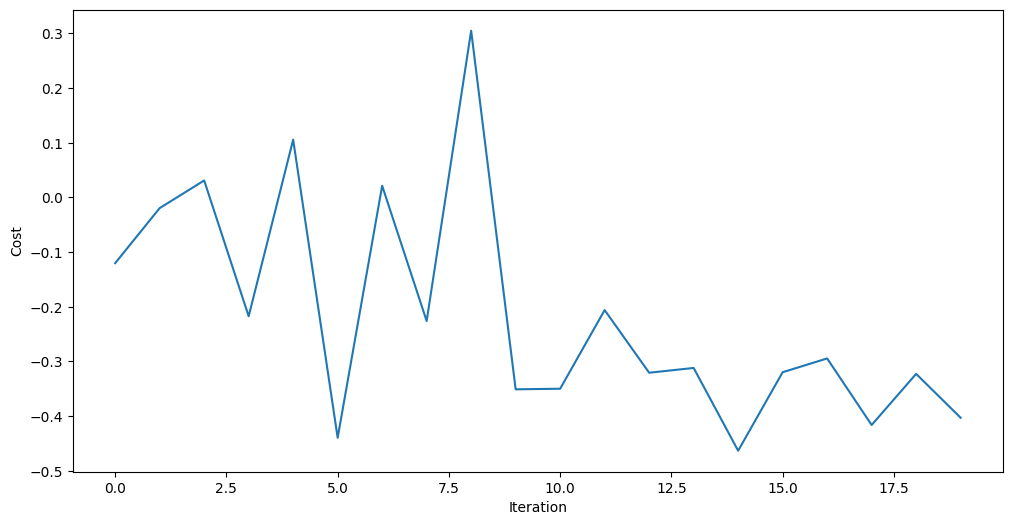

In [ ]:
quantum.draw_objective_value()

{'param_initialization': 'gaussian', 'optimizer': 'COBYLA', 'qaoa_variant': 'vanilla', 'warm_start': False, 'errors': True, 'depth': 1, 'graph_size': 14, 'graph_name': 'F?~vw', 'time_elapsed': 939.8774628639221, 'quantum_func_evals': 15, 'obj_func_evolution': [array(0.12180068), array(-0.34349421), array(-0.06667865), array(0.82702254), array(-0.04453895), array(0.01171525), array(-0.27458627), array(-0.35409225), array(-0.55606572), array(-0.47890838), array(-0.46850635), array(-0.4642492), array(-0.46028785), array(-0.50005174), array(-0.56314536)], 'quantum_solution': [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0], 'quantum_obj_value': 9.349752683921997, 'classic_solution': '[1.0, 1.0, 1.0, 1.0, 0, 0, 0]', 'classic_value': 6.76637017433752}


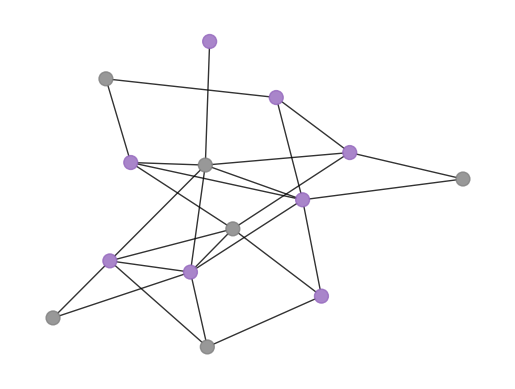

In [ ]:
quantum.plot_result()

streng = {'param_initialization': 'gaussian', 'optimizer': 'COBYLA','qaoa_variant': 'vanilla', 'warm_start' : False, 
    'errors':True, 'depth' : 1,'graph_size': len(graph.nodes()), 'graph_name' : name,
        'time_elapsed': quantum.time_elapsed, 'quantum_func_evals': quantum.fev, 'obj_func_evolution': quantum.objective_func_vals,
        'quantum_solution':quantum.solution, 'quantum_obj_value' : quantum.objective_value, 
        'classic_solution' : "[1.0, 1.0, 1.0, 1.0, 0, 0, 0]", 'classic_value': 6.76637017433752 }

print(streng)

strengkvante = {'param_initialization': 'gaussian', 'optimizer': 'COBYLA', 'qaoa_variant': 'vanilla', 'warm_start': False, 'errors': True, 'depth': 1, 'graph_size': 14, 'graph_name': 'F?~vw', 'time_elapsed': 939.8774628639221, 'quantum_func_evals': 15, 'obj_func_evolution': [array(0.12180068), array(-0.34349421), array(-0.06667865), array(0.82702254), array(-0.04453895), array(0.01171525), array(-0.27458627), array(-0.35409225), array(-0.55606572), array(-0.47890838), array(-0.46850635), array(-0.4642492), array(-0.46028785), array(-0.50005174), array(-0.56314536)], 'quantum_solution': [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0], 'quantum_obj_value': 9.349752683921997, 'classic_solution': '[1.0, 1.0, 1.0, 1.0, 0, 0, 0]', 'classic_value': 6.76637017433752}
strengklassisk = {'param_initialization': 'gaussian', 'optimizer': 'COBYLA', 'qaoa_variant': 'vanilla', 'warm_start': False, 'errors': True, 'depth': 1, 'graph_size': 14, 'graph_name': 'F?~vw', 'time_elapsed': 213.84445929527283, 'quantum_func_evals': 20, 'obj_func_evolution': [array(0.39734795), array(-1.0376927), array(-0.22653205), array(1.84816779), array(-0.30761412), array(-0.2709418), array(-0.94639894), array(-1.19304522), array(-1.18366792), array(-1.41863498), array(-1.49556211), array(-1.36082243), array(-1.4537323), array(-1.49466721), array(-1.40773976), array(-1.45808275), array(-1.45317739), array(-1.50052444), array(-1.47509223), array(-1.43506892)], 'quantum_solution': [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1], 'quantum_obj_value': 9.676471831056972, 'classic_solution': '[0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0]', 'classic_value': 10.437729676258234}


In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
import numpy as np
pub = (quantum.circuit,)
sampler = Sampler(mode=quantum.backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
print(counts_int)
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]





{109: 81, 52: 103, 82: 106, 112: 118, 84: 87, 91: 72, 21: 62, 64: 84, 26: 66, 60: 91, 46: 110, 81: 82, 23: 79, 98: 84, 74: 113, 76: 71, 102: 92, 96: 98, 38: 112, 31: 71, 2: 41, 28: 69, 71: 117, 5: 52, 62: 82, 95: 70, 22: 81, 108: 90, 92: 84, 10: 72, 68: 62, 105: 60, 126: 47, 61: 89, 88: 108, 124: 93, 42: 71, 70: 93, 63: 87, 69: 88, 90: 84, 66: 94, 56: 65, 20: 59, 7: 78, 117: 85, 78: 107, 27: 64, 115: 67, 49: 92, 39: 126, 12: 25, 119: 62, 103: 70, 47: 159, 16: 64, 100: 94, 127: 32, 75: 97, 6: 57, 80: 125, 15: 132, 33: 57, 94: 89, 54: 99, 111: 76, 30: 83, 14: 87, 83: 92, 9: 46, 67: 80, 106: 74, 121: 61, 86: 70, 44: 86, 29: 83, 97: 66, 101: 84, 17: 59, 120: 75, 36: 71, 79: 95, 122: 53, 18: 62, 19: 66, 125: 77, 114: 66, 113: 84, 116: 97, 51: 75, 87: 66, 11: 90, 37: 98, 104: 75, 99: 76, 57: 63, 58: 57, 4: 31, 85: 92, 43: 93, 45: 110, 13: 74, 72: 94, 41: 59, 40: 39, 118: 71, 53: 152, 65: 76, 32: 52, 93: 79, 77: 105, 110: 74, 48: 71, 123: 32, 107: 53, 3: 59, 34: 78, 50: 64, 59: 72, 89: 86, 35

In [ ]:
sorted_final_distribution_int = dict(sorted(final_distribution_int.items(), key=lambda item: item[1]))
print(sorted_final_distribution_int)

{0: 0.0014, 12: 0.0025, 1: 0.0026, 8: 0.0028, 4: 0.0031, 127: 0.0032, 123: 0.0032, 40: 0.0039, 2: 0.0041, 9: 0.0046, 126: 0.0047, 24: 0.0049, 5: 0.0052, 32: 0.0052, 122: 0.0053, 107: 0.0053, 6: 0.0057, 33: 0.0057, 58: 0.0057, 20: 0.0059, 17: 0.0059, 41: 0.0059, 3: 0.0059, 105: 0.006, 121: 0.0061, 21: 0.0062, 68: 0.0062, 119: 0.0062, 18: 0.0062, 25: 0.0062, 57: 0.0063, 27: 0.0064, 16: 0.0064, 50: 0.0064, 56: 0.0065, 26: 0.0066, 97: 0.0066, 19: 0.0066, 114: 0.0066, 87: 0.0066, 115: 0.0067, 28: 0.0069, 95: 0.007, 103: 0.007, 86: 0.007, 76: 0.0071, 31: 0.0071, 42: 0.0071, 36: 0.0071, 118: 0.0071, 48: 0.0071, 91: 0.0072, 10: 0.0072, 59: 0.0072, 106: 0.0074, 13: 0.0074, 110: 0.0074, 120: 0.0075, 51: 0.0075, 104: 0.0075, 111: 0.0076, 99: 0.0076, 65: 0.0076, 125: 0.0077, 7: 0.0078, 34: 0.0078, 23: 0.0079, 93: 0.0079, 67: 0.008, 109: 0.0081, 22: 0.0081, 81: 0.0082, 62: 0.0082, 30: 0.0083, 29: 0.0083, 64: 0.0084, 98: 0.0084, 92: 0.0084, 90: 0.0084, 101: 0.0084, 113: 0.0084, 117: 0.0085, 35: 0.00

C:\Users\torbjsme\AppData\Local\Temp\ipykernel_16596\1000029706.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")
C:\Users\torbjsme\AppData\Local\Temp\ipykernel_16596\1000029706.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_strings.append(int(p))


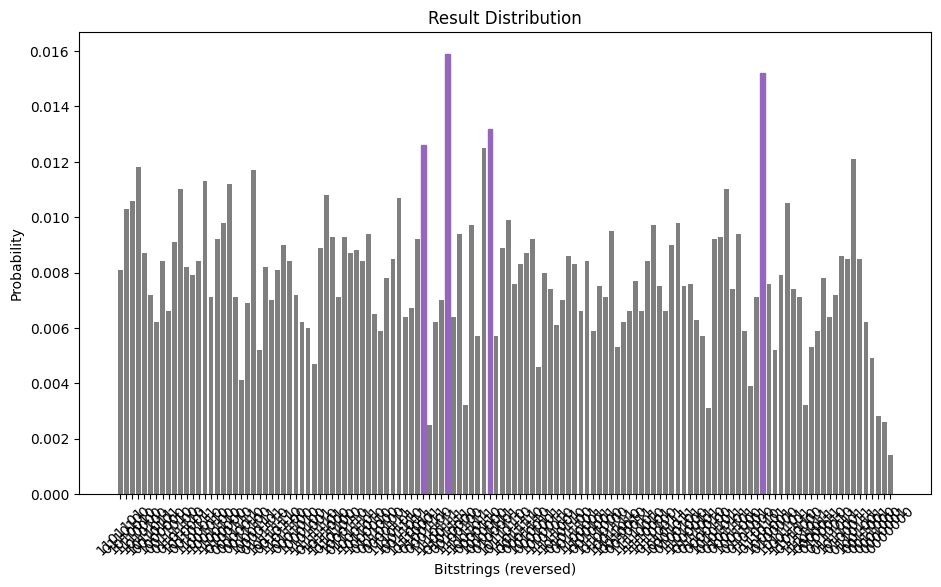

SOlution value for  [1, 1, 1, 0, 0, 1, 0]  from  39 is 5.247357048429492
SOlution value for  [1, 1, 1, 1, 0, 0, 0]  from  15 is 6.766370174337519
SOlution value for  [1, 0, 1, 0, 1, 1, 0]  from  53 is 5.324545454483055
SOlution value for  [1, 1, 1, 1, 0, 1, 0]  from  47 is 5.2360723265378155


In [ ]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
best_strings = []
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
    best_strings.append(int(p))
plt.show()
possible_string = [39,15,53,47]
for bitstring in possible_string:
    reversed_string = list(reversed(to_bitstring(bitstring, 7)))
    print('SOlution value for ',reversed_string,' from ' , bitstring, 'is',  quantum.solver.evaluate_bitstring(reversed_string))

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=params.api_key
)
job = service.job('cxeshvfky7rg0083qy00')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

AttributeError: 'QiskitRuntimeService' object has no attribute 'session'

In [ ]:
print({ 'time_elapsed': quantum.time_elapsed, 'quantum_func_evals': quantum.fev, 'obj_func_evolution': quantum.objective_func_vals,
        'quantum_solution':quantum.solution, 'quantum_obj_value' : quantum.objective_value})

{'time_elapsed': 91.7004942893982, 'quantum_func_evals': 656, 'obj_func_evolution': [array(0.00470049), array(0.22109304), array(0.00872167), array(-0.00807644), array(-0.07107055), array(0.07491817), array(-0.20840766), array(-0.01497535), array(-0.08585556), array(-0.3534936), array(-0.17826939), array(-0.15012535), array(-0.25469098), array(-0.17671295), array(-0.54110205), array(-0.47459626), array(-0.44239819), array(-0.67931793), array(-0.43452401), array(-0.16056975), array(-0.03639667), array(-0.55091322), array(-0.22153707), array(-0.44084087), array(-0.73890199), array(-0.58040153), array(-0.63590349), array(-0.94760893), array(-0.96209506), array(-0.64091514), array(-0.93292884), array(-0.08495125), array(-0.69270783), array(-0.89210157), array(-0.52817858), array(-0.42949235), array(-0.82546157), array(-0.94472689), array(-0.91142489), array(-0.87374493), array(-0.84403047), array(-0.95352249), array(-0.89873879), array(-0.92491652), array(-0.88561971), array(-0.93823792), 

In [ ]:
print(quantum.rqaoa._optimizer._min_eigen_solver)

AttributeError: 'QAOArunner' object has no attribute 'rqaoa'

In [ ]:
import itertools

iterables = [params.supported_qaoa_variants, params.supported_param_inits]

settings = []
for t in itertools.product(*iterables):
    settings.append(t)
for params in settings:
    print('Params:', params)
    qaoa = QAOArunner(graph, simulation=True, param_initialization=params[1],qaoa_variant=params[0])
    qaoa.build_circuit()
    qaoa.run()

Params: ('vanilla', 'uniform')
You are running on the local simulator:  fake_brisbane


KeyboardInterrupt: 

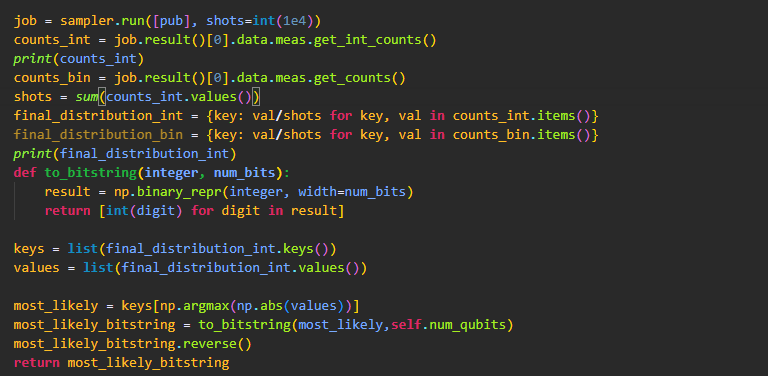

In [ ]:
#the data given here is the "job" from the picture above
data = qaoa.get_data_structures()


ValueError: The number of values (0) does not match the number of parameters (6) for the circuit. Note that if you want to run a single pub, you need to wrap it with `[]` like `sampler.run([(circuit, param_values)])` instead of `sampler.run((circuit, param_values))`.

In [ ]:
from solver import Solver


solver = Solver(graph, restrictions=False)
quantum.compare_solutions(solver.solve())

Result quantum [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0] Objective value:  14
Result input (classical) [0, 1.0, 1.0, 0, 0, 1.0, 0, 1.0, 0, 0, 1.0] Objective Value:  14.0
Same solution True
Same objective function value:  True


In [ ]:
quantum.get_prob_distribution()

{933: 11, 1210: 84, 422: 68, 1008: 13, 427: 10, 752: 20, 857: 204, 53: 1, 1649: 36, 665: 3, 838: 47, 741: 8, 854: 4, 1710: 8, 1214: 29, 837: 82, 1190: 176, 345: 14, 1182: 33, 1654: 4, 881: 117, 1208: 23, 438: 20, 969: 14, 1137: 5, 824: 20, 1242: 115, 589: 2, 346: 12, 1233: 23, 1189: 37, 1162: 5, 653: 7, 816: 5, 1776: 13, 1253: 11, 828: 25, 1350: 16, 1446: 33, 1613: 5, 1589: 13, 625: 21, 1383: 16, 825: 103, 1528: 1, 1161: 9, 327: 13, 270: 5, 1230: 23, 1291: 19, 780: 8, 1232: 19, 769: 4, 1696: 1, 1251: 41, 1164: 5, 796: 32, 1254: 56, 473: 10, 785: 15, 710: 20, 806: 75, 843: 65, 1752: 28, 1475: 1, 1195: 34, 1861: 10, 331: 24, 1573: 67, 1274: 12, 813: 48, 822: 15, 1597: 5, 1123: 17, 1721: 11, 1777: 6, 1327: 20, 1191: 59, 1319: 43, 782: 40, 1549: 25, 1355: 56, 501: 1, 948: 36, 924: 8, 176: 1, 569: 17, 369: 8, 548: 3, 483: 9, 798: 6, 1701: 11, 1163: 29, 1690: 2, 692: 56, 286: 4, 1265: 44, 430: 35, 1412: 1, 1012: 13, 1379: 17, 1294: 15, 1169: 4, 1741: 1, 1158: 11, 218: 14, 182: 10, 826: 21, 1

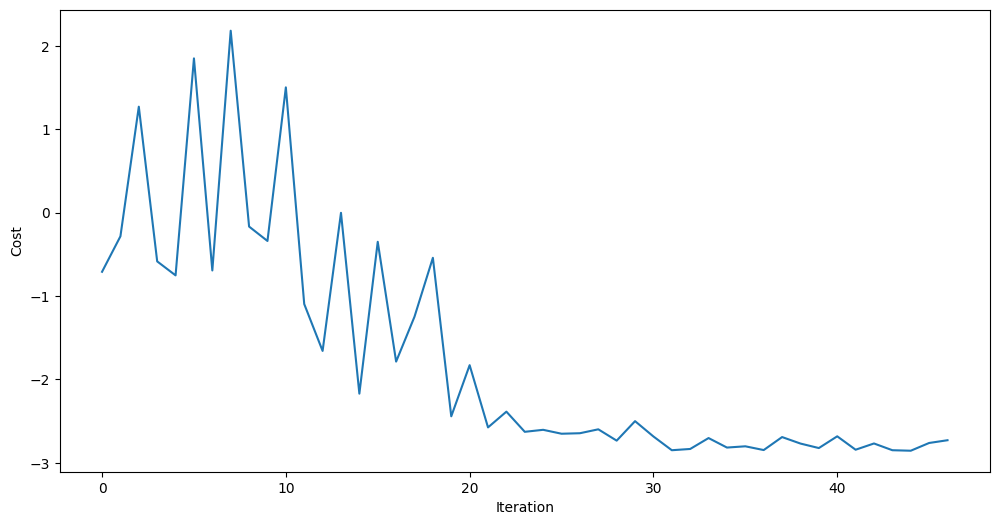

In [ ]:
quantum.draw_objective_value()

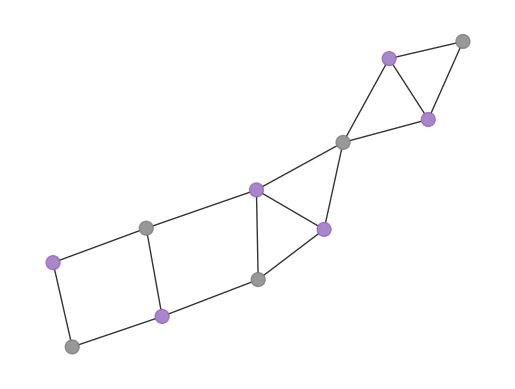

In [ ]:
quantum.plot_result()

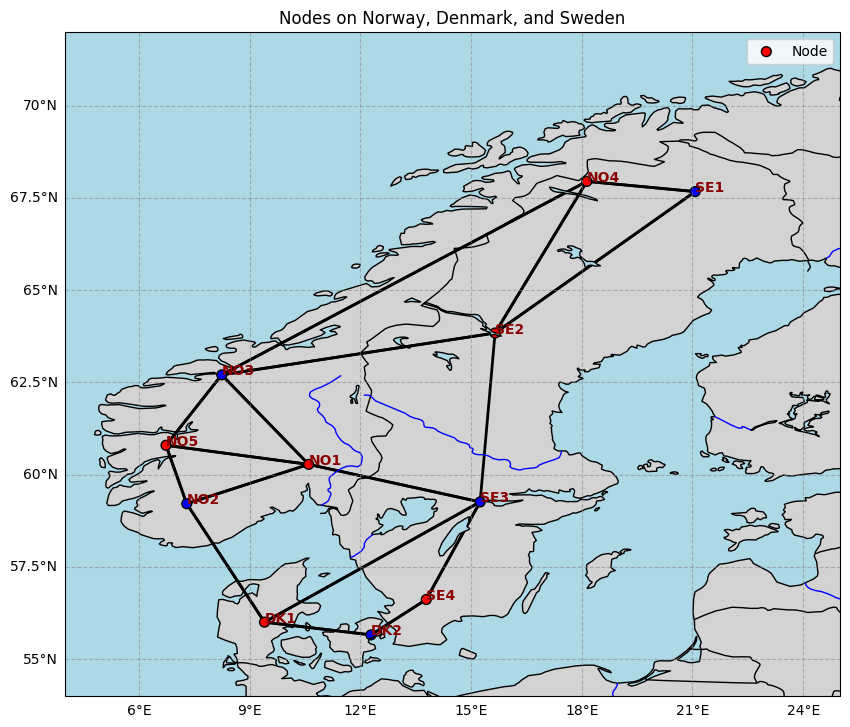

In [ ]:
import csv

import numpy as np
import rustworkx as rx
from rustworkx import is_connected
from rustworkx.visualization import mpl_draw as draw_graph
import pandas as pd
#import geopandas as gpd
#import cartopy.feature as cfeature

#import cartopy.crs as ccrs
import matplotlib.pyplot as plt

def load_edges_verbose(file_path):
    df = pd.read_csv(file_path,delimiter=';',index_col=0)
    result = [(row, col, 1) for (row, col), value in df.stack().items() if value == 1]
    return result


def draw_nodes_on_cartopy(file_path, bitstring=None):
    
    df = pd.read_csv(file_path, delimiter=';')
    edges = load_edges_verbose('data/11_nodes_links_scand.csv')
    
    # Rename the first column
    df.rename(columns={df.columns[0]: 'name'}, inplace=True)
    # Set up a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['y'], df['x']))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add map features
    ax.set_extent([4, 25, 54, 72], crs=ccrs.PlateCarree())  # Set the extent to cover Norway, Denmark, Sweden
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.LAKES, facecolor='lightblue', edgecolor='black')
    ax.add_feature(cfeature.RIVERS, edgecolor='blue')
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
  
    # Plot nodes on the map
    
    
    for start_label, end_label, weight in edges:
        start_coords = (df[df['name']==start_label]['y'], df[df['name']==start_label]['x'])
        end_coords = (df[df['name']==end_label]['y'], df[df['name']==end_label]['x'])
        ax.plot(
            [start_coords[0], end_coords[0]],  # x-coordinates (longitudes)
            [start_coords[1], end_coords[1]],  # y-coordinates (latitudes)
            color='black', linewidth=1 + weight, transform=ccrs.PlateCarree(), zorder=1
        )
    if bitstring is not None:
        colors = ['red' if bit == 1 else 'blue' for bit in bitstring]
    else:
        colors = 'red'
    
    gdf.plot(ax=ax, color=colors, markersize=50, transform=ccrs.PlateCarree(), edgecolor='black', label='Node')

    for idx, row in gdf.iterrows():
        ax.text(row.geometry.x + 0.005, row.geometry.y, row['name'], transform=ccrs.PlateCarree(),
                ha='left', fontsize=10, color='darkred', fontweight='bold')

    
    plt.legend()
    plt.title("Nodes on Norway, Denmark, and Sweden")
    plt.show()
draw_nodes_on_cartopy('data/11_nodes_coords_scand.csv', bitstring=quantum.solution)



